In [1]:
import os
import numpy as np
import random
import tensorflow as tf

seed = 1729959202

np.random.seed(seed)

random.seed(seed)

tf.random.set_seed(seed)

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam



gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7500)]
)

2024-11-10 14:19:41.287625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731244781.297899    2265 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731244781.300925    2265 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 14:19:41.312264: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


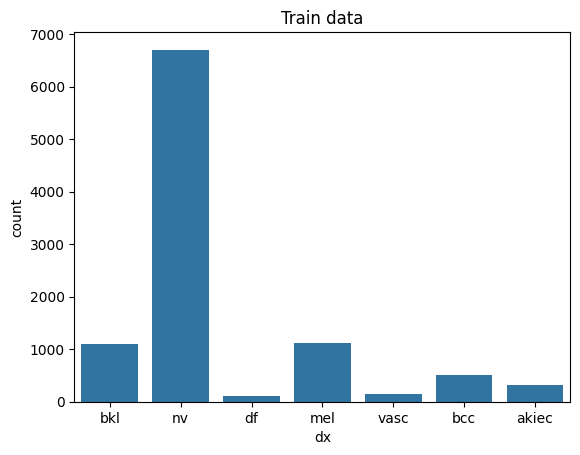

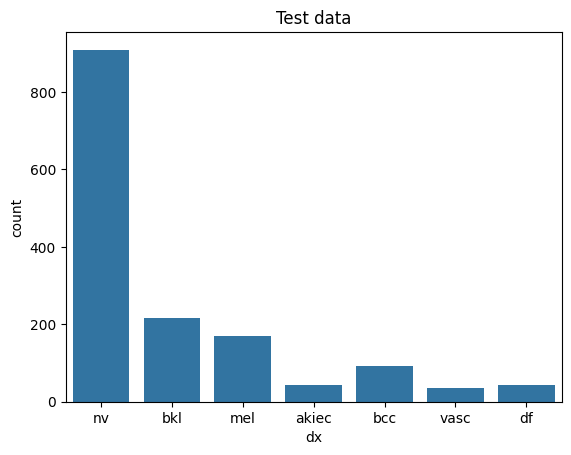

In [2]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  
test_image_dir = 'data/ham10000/images/test_images/'

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.title('Train data')
plt.show()

test_data_path = 'data/ham10000/images/ISIC2018_Task3_Test_GroundTruth.csv'

test_df = pd.read_csv(test_data_path)
test_df['image_path'] = test_image_dir + test_df['image_id'] + '.jpg'
test_df['label'] = label_encoder.transform(test_df['dx'])

sns.countplot(x='dx', data=test_df)
plt.title('Test data')
plt.show()

train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

In [3]:
# Extract only the image name and extension for each set
train_set = set(os.path.basename(path) for path in train_df['image_path'])
val_set = set(os.path.basename(path) for path in val_df['image_path'])
test_set = set(os.path.basename(path) for path in test_df['image_path'])

# print the path of the first image in the training set and the test set
print("First image in the training set:", list(train_set)[0])
print("First image in the test set:", list(test_set)[0])



print("Overlaps between train and validation:", len(train_set.intersection(val_set)))
print("Overlaps between train and test:", len(train_set.intersection(test_set)))
print("Overlaps between validation and test:", len(val_set.intersection(test_set)))

First image in the training set: ISIC_0028509.jpg
First image in the test set: ISIC_0035012.jpg
Overlaps between train and validation: 0
Overlaps between train and test: 0
Overlaps between validation and test: 0


In [4]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [5]:
image_size = (128, 128)
batch_size = 128
num_classes = len(df['dx'].unique())
img_height, img_width = image_size

def load_and_preprocess_image(image_path, label, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0  

    if augment:
        img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))  
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)

    return img, label

def create_dataset(df, augment=False, batch_size=32):
    df = df[df['image_path'].apply(os.path.exists)]
    
    image_paths = df['image_path'].values
    labels = df['label'].values
    labels = tf.keras.utils.to_categorical(labels, num_classes)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def preprocess_with_augment(image_path, label):
        return load_and_preprocess_image(image_path, label, augment)

    dataset = dataset.map(preprocess_with_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

train_dataset = create_dataset(train_df, augment=True, batch_size=batch_size)
val_dataset = create_dataset(val_df, batch_size=batch_size)
# test_dataset = create_dataset(test_df, batch_size=batch_size)


I0000 00:00:1731244783.452270    2265 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7500 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


In [6]:
import optuna
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [7]:
def build_model(trial):
    conv_1_filters = trial.suggest_int('conv_1_filters', 32, 256, step=32)
    conv_2_filters = trial.suggest_int('conv_2_filters', 32, 128, step=32)
    conv_3_filters = trial.suggest_int('conv_3_filters', 32, 64, step=16)
    dense_units = trial.suggest_int('dense_units', 64, 256, step=64)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])


    model = Sequential()
    input_shape = (128, 128, 3)
    model.add(Input(input_shape))
    
    model.add(Conv2D(
        filters=conv_1_filters,
        kernel_size=(2, 2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=conv_2_filters,
        kernel_size=(2, 2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=conv_3_filters,
        kernel_size=(2, 2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model



In [8]:
def objective(trial):
    model = build_model(trial)
    

    # Fit the model
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        verbose=0)

    # Return the validation accuracy
    return history.history['val_accuracy'][-1]

In [9]:
# Set up and optimize the Optuna study
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(), study_name='random_search_optuna1', storage='sqlite:///optuna/db.sqlite3', load_if_exists=True)  # We are maximizing validation accuracy
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found
print('Best hyperparameters:', study.best_params)

[I 2024-11-10 14:19:44,042] Using an existing study with name 'random_search_optuna1' instead of creating a new one.
I0000 00:00:1731244785.447790    2338 service.cc:148] XLA service 0x7f0388005150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731244785.447821    2338 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-11-10 14:19:45.485211: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731244785.621907    2338 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-10 14:19:46.003109: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_996', 12 bytes spill stores, 16 bytes spill loads

I0000 00:00:1731244790.096503    2338 device_compiler.h:188] Compiled cluster usin

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2265/1636274484.py", line 3, in <module>

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/optuna/study/study.py", line 475, in optimize

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 63, in _optimize

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 160, in _optimize_sequential

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial

  File "/tmp/ipykernel_2265/3659800922.py", line 6, in objective

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/bosa/manu/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 6862541312 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_60754]

In [11]:
study.best_params

{'conv_1_filters': 64,
 'conv_2_filters': 128,
 'conv_3_filters': 32,
 'dense_units': 192,
 'learning_rate': 0.0007870645661886023,
 'activation': 'relu'}

In [13]:
best_model = Sequential()
input_shape = (128, 128, 3)
best_model.add(Input(input_shape))

best_model.add(Conv2D(
    filters=study.best_params['conv_1_filters'],
    kernel_size=(2, 2),
    activation=study.best_params['activation']))

best_model.add(MaxPooling2D(pool_size=(2, 2)))

best_model.add(Conv2D(
    filters=study.best_params['conv_2_filters'],
    kernel_size=(2, 2),
    activation=study.best_params['activation']))

best_model.add(MaxPooling2D(pool_size=(2, 2)))

best_model.add(Conv2D(
    filters=study.best_params['conv_3_filters'],
    kernel_size=(2, 2),
    activation=study.best_params['activation']))

best_model.add(MaxPooling2D(pool_size=(2, 2)))

best_model.add(Flatten())

best_model.add(Dense(units=study.best_params['dense_units'], activation=study.best_params['activation']))

best_model.add(Dropout(0.5))

best_model.add(Dense(7, activation='softmax'))

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(study.best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history = best_model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    verbose=1)

# evaluate best model

test_dataset = create_dataset(test_df, batch_size=batch_size)




Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - accuracy: 0.6403 - loss: 1.2131 - val_accuracy: 0.6697 - val_loss: 0.9766
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.6713 - loss: 0.9860 - val_accuracy: 0.6687 - val_loss: 0.9399
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6713 - loss: 0.9296 - val_accuracy: 0.6707 - val_loss: 0.9032
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.6741 - loss: 0.8845 - val_accuracy: 0.6906 - val_loss: 0.8663
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.6821 - loss: 0.8580 - val_accuracy: 0.6976 - val_loss: 0.8643
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6908 - loss: 0.8327 - val_accuracy: 0.7096 - val_loss: 0.8274
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.7062 - loss: 0.8157 - val_accuracy: 0.7076 - val_loss: 0.8182
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7133 - loss: 0.7800 - val_accuracy: 0.7056 -

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7044 - loss: 0.8648

2024-11-10 14:45:41.798440: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_95', 348 bytes spill stores, 348 bytes spill loads



12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.6987 - loss: 0.8799
Test Accuracy: 0.667107880115509


2024-11-10 14:45:43.543235: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Best model OVO AUC: 0.867872340998211
Best model OVR AUC: 0.867872340998211
Best model F1 Score: 0.6085197795645046


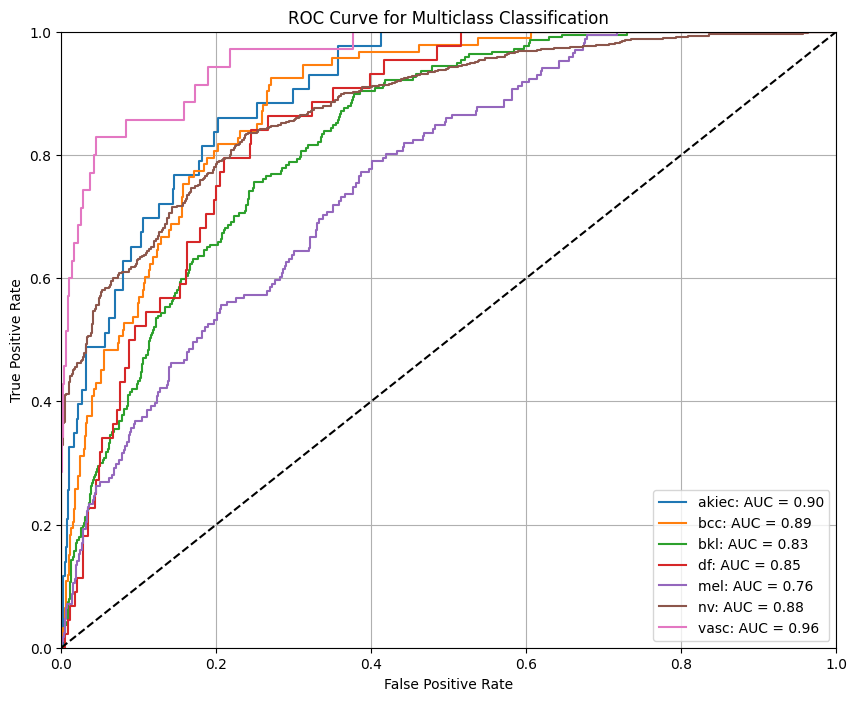

In [14]:
# Evaluate the best model on the test dataset
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc}')

# Calculate AUC and F1 scores
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_score = best_model.predict(test_dataset)

baseline_ovo_auc = roc_auc_score(y_true, y_score, multi_class="ovo")
baseline_ovr_auc = roc_auc_score(y_true, y_score, multi_class="ovr")
baseline_f1_score = f1_score(y_true.argmax(axis=1), y_score.argmax(axis=1), average="weighted")

print(f'Best model OVO AUC: {baseline_ovo_auc}')
print(f'Best model OVR AUC: {baseline_ovr_auc}')
print(f'Best model F1 Score: {baseline_f1_score}')

# Plot ROC curves
y_true = to_categorical(np.argmax(y_true, axis=1), num_classes)
class_names = label_encoder.inverse_transform(np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]}: AUC = {roc_auc[i]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()